In [11]:
"""
Authors: Yingquan Li, Thomas Inglesby
Date: April, 2019
Data: daily Bitcoin close prices from December,2018 to March,2019 along with other key Bitcoin metrics. 

This project used a dataset of Bitcoin prices that included stock trading attributes and corresponding tweets 
about Bitcoin trends. The goal was to build a machine learning model that forecasts Bitcoin's daily closing price.
Submissions were graded on mean absolute percentage error.

Our results were not great, but this was a really good data science project that Thomas and I had a lot of fun 
working on. For something that we did after work when we were both tired, I'm pretty happy with what we did. 
"""

In [ ]:
# Text and plotting libraries
import pandas as pd
import re
import os
import codecs
import numpy as np
import seaborn as sns
import string 
import nltk
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from nltk.corpus import stopwords
stop = stopwords.words('english')

import matplotlib.pyplot as plt
%matplotlib inline

# Change to working directory
os.chdir("C://Users//yingquli//Desktop//Bitcoin_Data2")

In [12]:
# Importing sklearn libraries; Feature Engineering and Scaling libraries
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import (RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor)
from sklearn.feature_selection import RFE
from sklearn.linear_model import (LinearRegression, Lasso, Ridge)

# Importing sklearn libraries; Modeling libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from math import sqrt

#### MODEL TRAINING STAGE ####

In [13]:
# Working files:
# train_timeseries2.csv

# Reading in the working file
time = pd.read_csv("train_timeseries2.csv", index_col = "date")

In [14]:
# Moving the 'close' variable to the end of the file
time = time[[c for c in time if c not in ['close']] + ['close']]

# Displaying a cut of the data and the dimensions of the data
display(time.head())
display(time.shape)

# Splitting data into the independent and dependent variables
X = time.iloc[:, 0:45]
y = time.iloc[:, -1]

,avg_block_size,blocks_size,cost_per_transaction_percent,cost_per_transaction,difficulty,est_transaction_volume_USD,est_transaction_volume,hash_rate,median_confirmation_time,miners_revenue,...,transactions_per_sec_max,utxo_count_mean,utxo_count_stddev,utxo_count_min,utxo_count_max,news_stories_total,news_stories_positive,news_stories_negative,news_stories_neutral,close
date,,,,,,,,,,,,,,,,,,,,,
2016-04-24,0.728040,66022.67805,1.385967,8.360698,1.786780e+11,110486293.2,240501.2912,1172443.384,8.783333,1531303.620,...,4.266667,36783070.63,27228.75866,36724621,36825214,6,2,0,4,458.55
2016-04-25,0.874485,66133.73765,0.888460,6.861613,1.786780e+11,168025613.1,362233.4608,1128032.650,9.683333,1492839.928,...,8.016667,36870963.17,17998.12914,36825828,36893715,25,7,8,10,461.43
2016-04-26,0.813180,66256.52779,1.129962,7.675906,1.786780e+11,170332016.5,363972.8546,1341204.175,7.750000,1924687.353,...,9.500000,36931936.13,16768.83707,36895435,36980350,32,14,14,4,466.09
2016-04-27,0.875343,66369.44708,0.873767,6.111057,1.786780e+11,167458968.2,374368.9346,1145796.944,10.366667,1463200.885,...,13.300000,37022472.54,16423.15703,36983148,37044068,18,8,4,6,444.69
2016-04-28,0.898219,66491.60486,0.904082,6.261128,1.786660e+11,171720826.0,381601.8356,1207843.183,10.000000,1552496.677,...,11.250000,37077491.25,18568.44670,37046272,37106607,24,12,7,5,449.01


(951, 46)

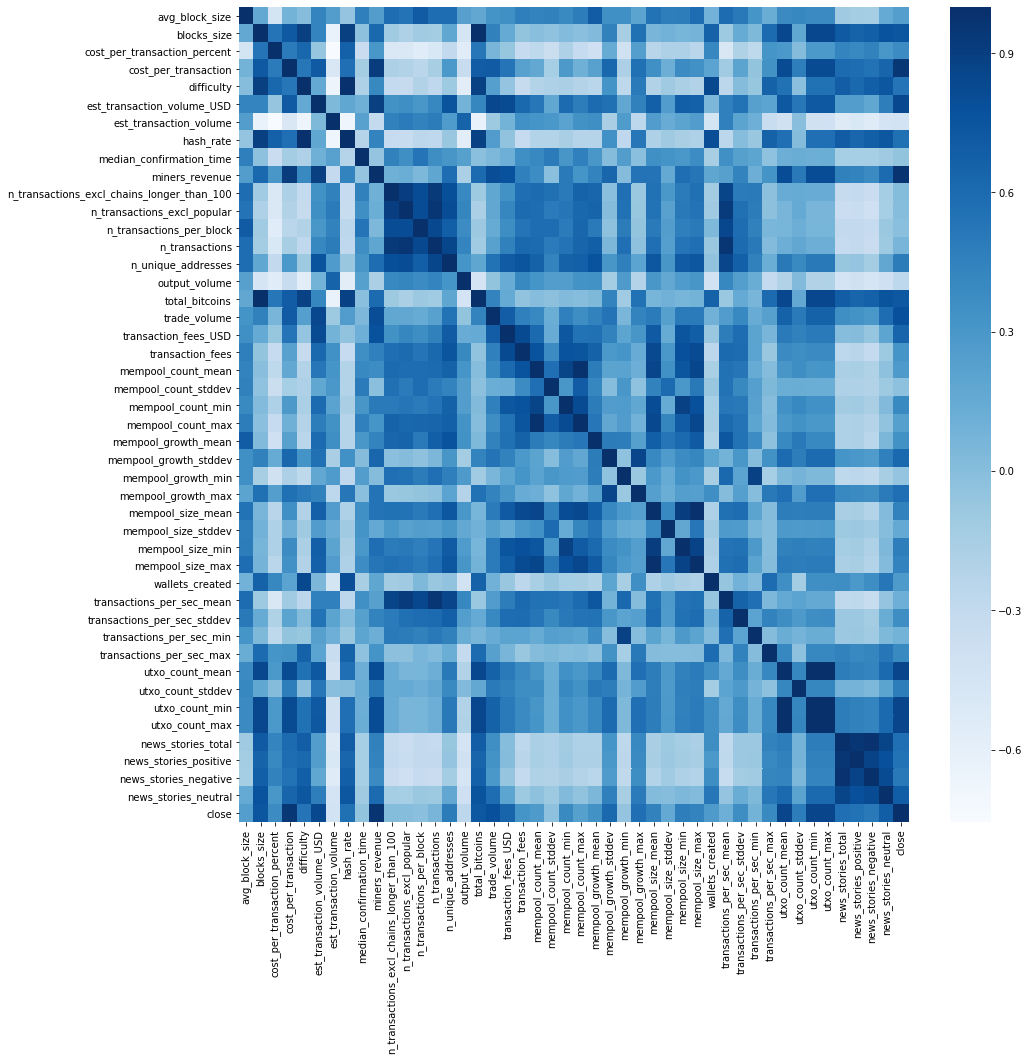

In [15]:
# Need to work on the labeling
plt.figure(figsize = (15, 15))
sns.heatmap(time.corr(), cmap="Blues", xticklabels=True, yticklabels=True)

In [16]:
# Min-Max Scaling of all the input features
scaler = MinMaxScaler()
time.loc[:, time.columns != "close"] = scaler.fit_transform(time.loc[:, time.columns != "close"])

In [ ]:
# Feature engineering. Features selected with Recursive Feature Elimination using an ensemble of models. 
# Had the Recursive Feature Elimination algorithm select the best features from the models: Linear Regression, 
# Lasso Regression, Ridge Regression, Random Forest, AdaBoost, Gradient Boosting. The best features were 
# selected at the following cutoffs: top-10, top-15, top-20, top-25.

# Recursive feature elimination with Linear Regression
lr = LinearRegression()
featureSelector = RFE(lr, n_features_to_select = 10, verbose = 3)

featureSelector.fit(X.values, y.values)

featuresBoolean = np.array(featureSelector.support_)
features = np.array(X.columns)
resultLR = features[featuresBoolean]

# Recursive feature elimination with Lasso Regression
lasso = Lasso()
featureSelector = RFE(lasso, n_features_to_select = 10)

featureSelector.fit(X.values, y.values)

featuresBoolean = np.array(featureSelector.support_)
features = np.array(X.columns)
resultLasso = features[featuresBoolean]

# Recursive feature elimination with Ridge Regression
ridge = Ridge()
featureSelector = RFE(ridge, n_features_to_select = 10)

featureSelector.fit(X.values, y.values)

featuresBoolean = np.array(featureSelector.support_)
features = np.array(X.columns)
resultRidge = features[featuresBoolean]

# Recursive feature elimination with Random Forest
rf = RandomForestRegressor(n_estimators = 200)
featureSelector = RFE(rf, n_features_to_select = 10)

featureSelector.fit(X.values, y.values)

featuresBoolean = np.array(featureSelector.support_)
features = np.array(X.columns)
resultRF = features[featuresBoolean]

# Recursive feature elimination with AdaBoost
ab = AdaBoostRegressor(n_estimators = 200)
featureSelector = RFE(ab, n_features_to_select = 10)

featureSelector.fit(X.values, y.values)

featuresBoolean = np.array(featureSelector.support_)
features = np.array(X.columns)
resultAB = features[featuresBoolean]

# Recursive feature elimination with Gradient Boosting 
gb = GradientBoostingRegressor(n_estimators = 200, learning_rate = 0.05)
featureSelector = RFE(gb, n_features_to_select = 10)

featureSelector.fit(X.values, y.values)

featuresBoolean = np.array(featureSelector.support_)
features = np.array(X.columns)
resultGB = features[featuresBoolean]

In [ ]:
# Created a dictionary that iterates through all the features that each model selected. Get a count of the 
# features that are selected by multiple models. Most selected features by different models are the most 
# important. Got the top-10, top-15, top-20 and top-25 features selected based on the aggregation of all six
# models.

importantFeatureDict = {}

for i in range(0, 10):
    # Linear Regression
    if resultLR[i] not in importantFeatureDict:
        importantFeatureDict[resultLR[i]] = 1
    else:
         importantFeatureDict[resultLR[i]] += 1
    
    # Lasso
    if resultLasso[i] not in importantFeatureDict:
        importantFeatureDict[resultLasso[i]] = 1
    else:
         importantFeatureDict[resultLasso[i]] += 1
    
    # Ridge
    if resultRidge[i] not in importantFeatureDict:
        importantFeatureDict[resultRidge[i]] = 1
    else:
         importantFeatureDict[resultRidge[i]] += 1
    
    # Random Forest
    if resultRF[i] not in importantFeatureDict:
        importantFeatureDict[resultRF[i]] = 1
    else:
         importantFeatureDict[resultRF[i]] += 1
       
    # Ada Boost
    if resultAB[i] not in importantFeatureDict:
        importantFeatureDict[resultAB[i]] = 1
    else:
         importantFeatureDict[resultAB[i]] += 1
            
    # Gradient Boosting
    if resultGB[i] not in importantFeatureDict:
        importantFeatureDict[resultGB[i]] = 1
    else:
         importantFeatureDict[resultGB[i]] += 1

In [7]:
# Put all the top features into an excel. Based on the results, an executive decision was made to go with the 
# top 19 features. Using 10 features left out too many important features and using 25 features included too many 
# irrelevant features.

# List of features for modeling after Recursive Feature Elimination and model ensembling
columns = ['cost_per_transaction',
'transaction_fees',
'n_transactions_per_block',
'transactions_per_sec_mean',
'median_confirmation_time',
'news_stories_negative',
'blocks_size',
'est_transaction_volume_USD',
'hash_rate',
'miners_revenue',
'mempool_growth_mean',
'total_bitcoins',
'transactions_per_sec_stddev',
'transactions_per_sec_max',
'news_stories_total',
'news_stories_positive',
'utxo_count_min',
'news_stories_neutral',
'close']

# Extract the important features and display a few rows
timeTrain = time[columns]
display(timeTrain.head())
timeTrain.shape

,cost_per_transaction,transaction_fees,n_transactions_per_block,transactions_per_sec_mean,median_confirmation_time,news_stories_negative,blocks_size,est_transaction_volume_USD,hash_rate,miners_revenue,mempool_growth_mean,total_bitcoins,transactions_per_sec_stddev,transactions_per_sec_max,news_stories_total,news_stories_positive,utxo_count_min,news_stories_neutral,close
date,,,,,,,,,,,,,,,,,,,
2016-04-24,0.028448,0.014055,0.293042,0.147010,0.130927,0.000000,0.000000,0.006684,0.000731,0.012379,0.151748,0.000000,0.059934,0.005603,0.001632,0.001307,0.000000,0.012945,458.55
2016-04-25,0.018949,0.020816,0.465435,0.224299,0.169144,0.004343,0.000876,0.016801,0.000000,0.011644,0.202825,0.001644,0.134875,0.102586,0.007835,0.004575,0.003276,0.032362,461.43
2016-04-26,0.024109,0.219300,0.437611,0.290203,0.087049,0.007600,0.001845,0.017206,0.003510,0.019900,0.227308,0.003599,0.250764,0.140948,0.010121,0.009150,0.005529,0.012945,466.09
2016-04-27,0.014193,0.022712,0.541148,0.277035,0.198160,0.002172,0.002735,0.016701,0.000292,0.011077,0.217285,0.005269,0.286681,0.239224,0.005550,0.005229,0.008369,0.019417,444.69
2016-04-28,0.015144,0.025077,0.530897,0.297078,0.182590,0.003800,0.003699,0.017450,0.001314,0.012785,0.241667,0.007016,0.200289,0.186207,0.007509,0.007843,0.010412,0.016181,449.01


(951, 19)

In [8]:
# Spliting data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(timeTrain.iloc[:, 0:18], 
                                                    timeTrain.iloc[:, 18], 
                                                    test_size = .20, 
                                                    random_state = 0)

In [ ]:
# Training data dimensions
X_train.shape, y_train.shape

In [ ]:
# Testing data dimensions
X_test.shape, y_test.shape

In [9]:
# Decided to go with CART models only as the regressions were not giving good results.

# Random Forest Regression
print("RandomForest:")
rf = RandomForestRegressor(n_estimators = 200, max_depth = 6, oob_score = True)
rf.fit(X_train, y_train)

print('Coefficient of determination R^2 (training) score: {}'.format(rf.score(X_train, y_train)))
print('Coefficient of determination R^2 (testing) score: {}'.format(rf.score(X_test, y_test)))
print('\nOut-of-bag score: {}'.format(rf.oob_score_))

# AdaBoost Regression
print("\nAdaBoost:")
ab = AdaBoostRegressor(n_estimators = 200)
ab.fit(X_train, y_train)

print('Coefficient of determination R^2 (training) score: {}'.format(ab.score(X_train, y_train)))
print('Coefficient of determination R^2 (testing) score: {}'.format(ab.score(X_test, y_test)))

# GradientBoost Regression
print("\nGradientBoost:")
gb = GradientBoostingRegressor(n_estimators = 200)
gb.fit(X_train, y_train)

print('Coefficient of determination R^2 (training) score: {}'.format(gb.score(X_train, y_train)))
print('Coefficient of determination R^2 (testing) score: {}'.format(gb.score(X_test, y_test)))

RandomForest:
Coefficient of determination R^2 (training) score: 0.9965346217405345
Coefficient of determination R^2 (testing) score: 0.9867924624143918

Out-of-bag score: 0.9898182599951713

AdaBoost:
Coefficient of determination R^2 (training) score: 0.9816893228357055
Coefficient of determination R^2 (testing) score: 0.9700312127189704

GradientBoost:
Coefficient of determination R^2 (training) score: 0.999524465477573
Coefficient of determination R^2 (testing) score: 0.9917539748815719


In [ ]:
# Comparing the Test dataset (split from the TRAINING DATA) values with the predicted values
d = {'Y_test': y_test, 'Predicted': rf.predict(X_test)}
df = pd.DataFrame(data = d)

# Display a few rows of the actual vs. the predicted values
df.head(n = 25)

#### MODEL TESTING ####

In [10]:
# Working files:
# test_timeseries2.csv

# Reading in the working file
timeTest = pd.read_csv("test_timeseries2.csv", index_col = "date")

# Displaying a cut of the data and the dimensions of the data
display(timeTest.head())
display(timeTest.shape)

,avg_block_size,blocks_size,cost_per_transaction_percent,cost_per_transaction,difficulty,est_transaction_volume_USD,est_transaction_volume,hash_rate,median_confirmation_time,miners_revenue,...,transactions_per_sec_min,transactions_per_sec_max,utxo_count_mean,utxo_count_stddev,utxo_count_min,utxo_count_max,news_stories_total,news_stories_positive,news_stories_negative,news_stories_neutral
date,,,,,,,,,,,,,,,,,,,,,
2018-12-01,1.068438,192924.029808,0.923090,26.914157,6.653303e+12,7.051436e+08,171285.334800,4.101145e+07,11.866667,6.509108e+06,...,1.066667,20.683333,5.838090e+07,12711.208037,58353357.0,58406280.0,915.0,297.0,508.0,110.0
2018-12-02,1.005272,193038.630789,1.715932,27.105352,6.653303e+12,3.517405e+08,84399.905117,3.770407e+07,9.883333,6.035630e+06,...,0.850000,24.466667,5.839757e+07,12797.050623,58369018.0,58411610.0,879.0,287.0,497.0,95.0
2018-12-03,1.101028,193164.148009,0.455677,24.006523,6.194016e+12,1.267830e+09,319552.043684,3.199801e+07,11.150000,5.777218e+06,...,1.183333,26.566667,5.843081e+07,9615.069463,58408024.0,58447369.0,1119.0,386.0,552.0,181.0
2018-12-04,1.083460,193313.665436,0.279035,25.753689,5.646404e+12,2.493726e+09,629491.330519,3.873443e+07,9.800000,6.958363e+06,...,1.200000,26.100000,5.845325e+07,9025.975571,58439456.0,58464237.0,1112.0,383.0,541.0,188.0
2018-12-05,1.036768,193448.445287,0.442812,24.839415,5.646404e+12,1.438836e+09,372914.991753,3.648895e+07,9.300000,6.371335e+06,...,1.200000,26.050000,5.849635e+07,9608.661188,58473643.0,58511025.0,1040.0,359.0,532.0,149.0


(113, 45)

In [11]:
# Min-Max Scaling of all the input features
scaler = MinMaxScaler()
timeTestScaled = pd.DataFrame(scaler.fit_transform(timeTest), index = timeTest.index, columns = timeTest.columns)

display(timeTestScaled.head())
display(timeTestScaled.shape)

,avg_block_size,blocks_size,cost_per_transaction_percent,cost_per_transaction,difficulty,est_transaction_volume_USD,est_transaction_volume,hash_rate,median_confirmation_time,miners_revenue,...,transactions_per_sec_min,transactions_per_sec_max,utxo_count_mean,utxo_count_stddev,utxo_count_min,utxo_count_max,news_stories_total,news_stories_positive,news_stories_negative,news_stories_neutral
date,,,,,,,,,,,,,,,,,,,,,
2018-12-01,0.580997,0.000000,0.224807,0.503583,1.000000,0.212300,0.195980,0.439779,0.831754,0.421442,...,0.510417,0.451142,0.000000,0.192141,0.000000,0.000000,0.489879,0.458472,0.537736,0.289617
2018-12-02,0.469097,0.007079,0.501547,0.514528,1.000000,0.056660,0.043521,0.278407,0.549763,0.307945,...,0.375000,0.658447,0.001767,0.193869,0.001664,0.000565,0.441296,0.425249,0.511792,0.207650
2018-12-03,0.638729,0.014832,0.061657,0.337127,0.703088,0.460110,0.456145,0.000000,0.729858,0.246000,...,0.583333,0.773516,0.005289,0.129819,0.005808,0.004355,0.765182,0.754153,0.641509,0.677596
2018-12-04,0.607607,0.024068,0.000000,0.437148,0.349077,1.000000,1.000000,0.328680,0.537915,0.529134,...,0.593750,0.747945,0.007667,0.117961,0.009147,0.006143,0.755735,0.744186,0.615566,0.715847
2018-12-05,0.524893,0.032393,0.057166,0.384808,0.349077,0.535422,0.549782,0.219120,0.466825,0.388417,...,0.593750,0.745205,0.012234,0.129690,0.012779,0.011102,0.658570,0.664452,0.594340,0.502732


(113, 45)

In [12]:
# List of important variables
columns = ['cost_per_transaction',
'transaction_fees',
'n_transactions_per_block',
'transactions_per_sec_mean',
'median_confirmation_time',
'news_stories_negative',
'blocks_size',
'est_transaction_volume_USD',
'hash_rate',
'miners_revenue',
'mempool_growth_mean',
'total_bitcoins',
'transactions_per_sec_stddev',
'transactions_per_sec_max',
'news_stories_total',
'news_stories_positive',
'utxo_count_min',
'news_stories_neutral']

# Extract the important features and display a few rows
X_test2 = timeTestScaled[columns]
display(X_test2.head())
X_test2.shape

,cost_per_transaction,transaction_fees,n_transactions_per_block,transactions_per_sec_mean,median_confirmation_time,news_stories_negative,blocks_size,est_transaction_volume_USD,hash_rate,miners_revenue,mempool_growth_mean,total_bitcoins,transactions_per_sec_stddev,transactions_per_sec_max,news_stories_total,news_stories_positive,utxo_count_min,news_stories_neutral
date,,,,,,,,,,,,,,,,,,
2018-12-01,0.503583,0.715827,0.469494,0.127504,0.831754,0.537736,0.000000,0.212300,0.439779,0.421442,0.314011,0.000000,0.464827,0.451142,0.489879,0.458472,0.000000,0.289617
2018-12-02,0.514528,0.432501,0.472077,0.002220,0.549763,0.511792,0.007079,0.056660,0.278407,0.307945,0.130660,0.006994,0.328073,0.658447,0.441296,0.425249,0.001664,0.207650
2018-12-03,0.337127,0.716163,0.612919,0.249071,0.729858,0.641509,0.014832,0.460110,0.000000,0.246000,0.476988,0.013989,0.259739,0.773516,0.765182,0.754153,0.005808,0.677596
2018-12-04,0.437148,0.729604,0.476203,0.253842,0.537915,0.615566,0.024068,1.000000,0.328680,0.529134,0.402793,0.022455,0.255646,0.747945,0.755735,0.744186,0.009147,0.715847
2018-12-05,0.384808,0.542843,0.489771,0.289286,0.466825,0.594340,0.032393,0.535422,0.219120,0.388417,0.466444,0.030431,0.206112,0.745205,0.658570,0.664452,0.012779,0.502732


(113, 18)

In [13]:
# In the end the results were submitted as an ensemble model! The predictions from the Random Forest
# model, the adaBoost model and Gradient Boosting model were averaged to submit the final result.
# The features came from an ensemble and the model itself was also an ensemble.
zippedValues = zip(rf.predict(X_test2), ab.predict(X_test2), gb.predict(X_test2))

finalValues = [(i + j + k) / 3 for i, j, k in zippedValues]

In [16]:
rf.predict(X_test2)[0:5]

array([2909.85815527, 2729.6542419 , 2433.62273424, 3023.60331777,
       2896.86964734])

In [17]:
ab.predict(X_test2)[0:5]

array([10860.3991954 ,  8133.01698795,  7296.01865031, 11780.58823529,
        9615.09116279])

In [18]:
gb.predict(X_test2)[0:5]

array([5543.90341904, 5067.21903966, 4020.37153036, 6332.3030978 ,
       5295.58048554])

In [19]:
(5543.90341904 + 10860.3991954 + 2909.85815527) / 3

6438.053589903334

In [15]:
# Comparing the Test dataset values with the predicted values
d = {'date': timeTest.index, 'close': finalValues}
df = pd.DataFrame(data = d)
display(df.shape)

# Convert date to the right format
df['date'] = pd.to_datetime(df['date'])

# Display a few rows of the actual vs. the predicted values
display(df.head(n = 10))

#Write results to submission file
df.to_csv("submission_file_YL_TI_2.csv", sep = ',', index = False)

(113, 2)

,date,close
0,2018-12-01,6438.053590
1,2018-12-02,5309.963423
2,2018-12-03,4583.337638
3,2018-12-04,7045.498217
4,2018-12-05,5935.847099
5,2018-12-06,5831.550426
6,2018-12-07,906.219067
7,2018-12-08,4087.870174
8,2018-12-09,4419.218133
9,2018-12-10,2674.302583


#### NATURAL LANGUAGE PROCESS PART THAT DID NOT WORK ####

In [ ]:
# Working files:
# train_tweets.csv
with codecs.open("train_tweets.csv", 'r', encoding='utf-8', errors='ignore') as fdata:
    tweets = pd.read_csv(fdata)
    
tweets.head()

In [ ]:
tweets = tweets[tweets['text'].notnull()]

new = tweets["created_date"].str.split(" ", n = 1, expand = True) 
tweets["date"]= new[0] 
tweets["time"]= new[1]

tweets["text"] = tweets["text"].str.replace("@[\w]*|RT @[\w]*:|https://.*", "")
tweets['text'] = tweets['text'].str.replace("[^a-zA-Z#]", " ").str.lower()
tweets['text'] = tweets['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

tweets.head(n=100)

In [ ]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

def tokenize(s):
    return re_tok.sub(r' \1 ', s).split()

In [ ]:
tweets['text'] = tweets['text'].apply(tokenize)
tweets['text'] = tweets['text'].apply(lambda x: [item for item in x if item not in stop])

In [ ]:
tweets.head()